In [375]:
#загрузка необходимых библиотек и модулей
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

import statistics

from sklearn.model_selection import train_test_split
import catboost as catb

from sklearn.metrics import f1_score, roc_auc_score, precision_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
import seaborn as sns

%matplotlib inline

# Домашнее задание №6

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

### Решение

**1. Загрузка датасета**

Источник датасета: https://archive.ics.uci.edu/ml/datasets/Caesarian+Section+Classification+Dataset

*Описание датасета*\
Age -- возраст \
Delivery_Number -- номер поступления (1, 2, 3, 4)\
Delivery_Time -- время поступления (0 = своевремено, 1 = преждевремено, 2 = запоздалое)\
Blood_Pressure -- артериальное давление (0 = низкое, 1 = нормальное, 2 = высокое)\
Heart_Problem -- проблемы с сердцем (0 = нет, 1 = да)\
Caesarian -- проведение кесарева сечения (0 = нет, 1 = да)

In [376]:
# заголовки для признаков
_headers = ['Age', 'Delivery_Number', 'Delivery_Time', 'Blood_Pressure', 'Heart_Problem', 'Caesarian']
# загрузка датасета
df = pd.read_csv('caesarian.csv.arff', names=_headers, index_col=None, skiprows=15)
df.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem,Caesarian
0,22,1,0,2,0,0
1,26,2,0,1,0,1
2,26,2,1,1,0,0


In [377]:
#датасет содержит 80 наблюдений и 5 признаков
df.shape

(80, 6)

**2. feature engineering**

In [378]:
# Датасет для feature engineering
select = [x for x in df.columns if (x != "Caesarian")]
X = df.loc[:, select]
X.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem
0,22,1,0,2,0
1,26,2,0,1,0
2,26,2,1,1,0


Feature encoding

In [379]:
#Вычислям медианное значение Age по каждому значению следующих признаков
for feature in ['Delivery_Number','Delivery_Time', 'Blood_Pressure', 'Heart_Problem']:
    d = X.groupby(feature, as_index=False).median()[[feature,'Age']].rename(columns={
    'Age': f'Age encode {feature}'})
    X = X.merge(d, on=feature, how='left')
X.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem,Age encode Delivery_Number,Age encode Delivery_Time,Age encode Blood_Pressure,Age encode Heart_Problem
0,22,1,0,2,0,26.0,28,28.5,26
1,26,2,0,1,0,28.0,28,27.0,26
2,26,2,1,1,0,28.0,27,27.0,26


In [380]:
#Вычислям значение моды по каждому из следующих признаков в зависимости от возраста
for feature in ['Delivery_Number','Delivery_Time', 'Blood_Pressure', 'Heart_Problem']:
    d = X.groupby('Age', as_index=False)[feature].apply(statistics.mode)[['Age',feature]].rename(columns={
    feature: f'{feature} encode Age'})
    X = X.merge(d, on='Age', how='left')
X.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem,Age encode Delivery_Number,Age encode Delivery_Time,Age encode Blood_Pressure,Age encode Heart_Problem,Delivery_Number encode Age,Delivery_Time encode Age,Blood_Pressure encode Age,Heart_Problem encode Age
0,22,1,0,2,0,26.0,28,28.5,26,1,0,2,0
1,26,2,0,1,0,28.0,28,27.0,26,2,1,1,0
2,26,2,1,1,0,28.0,27,27.0,26,2,1,1,0


Target encoding

In [381]:
# target encording для количественного признака Age
for feature in ['Age']:
    t = pd.concat([X,df['Caesarian']], axis=1).\
         groupby(feature, as_index=False).median()[[feature, 'Caesarian']].\
         rename(columns={'Caesarian': f'Caesarian_encode_{feature}'})
    t = pd.DataFrame(t)
    X = X.merge(t, on=feature, how='left')
X.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem,Age encode Delivery_Number,Age encode Delivery_Time,Age encode Blood_Pressure,Age encode Heart_Problem,Delivery_Number encode Age,Delivery_Time encode Age,Blood_Pressure encode Age,Heart_Problem encode Age,Caesarian_encode_Age
0,22,1,0,2,0,26.0,28,28.5,26,1,0,2,0,0.5
1,26,2,0,1,0,28.0,28,27.0,26,2,1,1,0,0.0
2,26,2,1,1,0,28.0,27,27.0,26,2,1,1,0,0.0


In [382]:
# target encording для категориальных признаков
for feature in ['Delivery_Number', 'Delivery_Time', 'Blood_Pressure', 'Heart_Problem']:
    t = pd.concat([X,df['Caesarian']], axis=1).\
         groupby(feature, as_index=False)['Caesarian'].apply(statistics.mode)[[feature, 'Caesarian']].\
         rename(columns={'Caesarian': f'Caesarian_encode_{feature}'})
    t = pd.DataFrame(t)
    X = X.merge(t, on=feature, how='left')
X.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem,Age encode Delivery_Number,Age encode Delivery_Time,Age encode Blood_Pressure,Age encode Heart_Problem,Delivery_Number encode Age,Delivery_Time encode Age,Blood_Pressure encode Age,Heart_Problem encode Age,Caesarian_encode_Age,Caesarian_encode_Delivery_Number,Caesarian_encode_Delivery_Time,Caesarian_encode_Blood_Pressure,Caesarian_encode_Heart_Problem
0,22,1,0,2,0,26.0,28,28.5,26,1,0,2,0,0.5,1,1,1,0
1,26,2,0,1,0,28.0,28,27.0,26,2,1,1,0,0.0,1,1,0,0
2,26,2,1,1,0,28.0,27,27.0,26,2,1,1,0,0.0,1,0,0,0


In [383]:
#Собираем датасет после преобразования признаков
df = pd.concat([X, df['Caesarian']], axis=1)
df.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem,Age encode Delivery_Number,Age encode Delivery_Time,Age encode Blood_Pressure,Age encode Heart_Problem,Delivery_Number encode Age,Delivery_Time encode Age,Blood_Pressure encode Age,Heart_Problem encode Age,Caesarian_encode_Age,Caesarian_encode_Delivery_Number,Caesarian_encode_Delivery_Time,Caesarian_encode_Blood_Pressure,Caesarian_encode_Heart_Problem,Caesarian
0,22,1,0,2,0,26.0,28,28.5,26,1,0,2,0,0.5,1,1,1,0,0
1,26,2,0,1,0,28.0,28,27.0,26,2,1,1,0,0.0,1,1,0,0,1
2,26,2,1,1,0,28.0,27,27.0,26,2,1,1,0,0.0,1,0,0,0,0


In [384]:
#преобразованный датасет содержит 80 наблюдений и 18 признаков
df.shape

(80, 19)

**3. Обучение бинарного классификатора CatBoostClassifier**

In [385]:
#разделим данные на train/test
X = df.drop(['Caesarian'], axis=1)
y = df['Caesarian']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape, X_test.shape)

(60, 18) (20, 18)


In [386]:
#считаем дисбаланс
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

0.6666666666666666

In [387]:
model_catb = catb.CatBoostClassifier(silent=True, 
                                     random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=20,
                                     cat_features=['Delivery_Number', 'Delivery_Time', 'Blood_Pressure', 'Heart_Problem'],
                                     #iterations=40,
                                     #max_depth=4
                                     )
#обучаем модель
model_catb.fit(X_train, y_train)

#делаем прогнозы для тестовой выборки
preds = model_catb.predict_proba(X_test)[:, 1]
preds[:10]

array([0.3824724 , 0.25157842, 0.58807097, 0.819764  , 0.38295048,
       0.85858996, 0.33067871, 0.58807097, 0.11336711, 0.81612356])

Значения метрик

In [388]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
boost_metrics = [fscore[ix], precision[ix], recall[ix]]

Best Threshold=0.330679, F-Score=0.720, Precision=0.600, Recall=0.900


Поиск лучших параметров модели

In [389]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'eval_metric':'F1',
     'early_stopping_rounds':20,
     'cat_features' : ['Delivery_Number', 'Delivery_Time', 'Blood_Pressure', 'Heart_Problem']
    }


model_catb = catb.CatBoostClassifier(**frozen_params)

params = {'iterations':[20, 40, 50, 100, 200, 500, 700, 1000],
          'max_depth':[2, 3, 4, 5, 7,10]}
#перебор
grid = GridSearchCV(model_catb,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'iterations': 40, 'max_depth': 4}

In [390]:
model_catb = catb.CatBoostClassifier(**frozen_params,
                                      iterations=40,
                                        max_depth=4
                                       )

model_catb.fit(X_train, y_train)

#делаем прогнозы для тестовой выборки
preds = model_catb.predict_proba(X_test)[:, 1]
preds[:10]

array([0.4341224 , 0.34716473, 0.49842223, 0.67237347, 0.38721908,
       0.71039914, 0.36301484, 0.49842223, 0.27562354, 0.66300572])

In [391]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
boost_metrics = [fscore[ix], precision[ix], recall[ix]]

Best Threshold=0.363015, F-Score=0.720, Precision=0.600, Recall=0.900


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


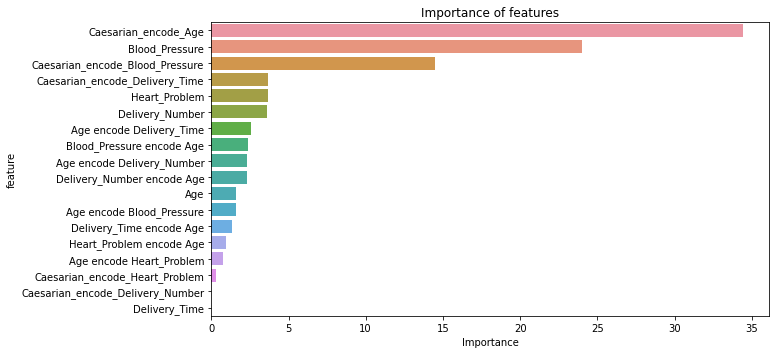

In [392]:
#важность признаков
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.3))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=10)

**4. Разделение данных на два множества: P (positives) и U (unlabeled)**

In [394]:
df_P = df.loc[df['Caesarian'] == 1] #positives
df_U = df.loc[df['Caesarian'] == 0] #unlabeled

data_P = df_P.sample(frac=0.8) #берем не все positivies, а только часть
data_U = df_U
data = pd.concat([data_P, data_U], ignore_index=True)
data.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem,Age encode Delivery_Number,Age encode Delivery_Time,Age encode Blood_Pressure,Age encode Heart_Problem,Delivery_Number encode Age,Delivery_Time encode Age,Blood_Pressure encode Age,Heart_Problem encode Age,Caesarian_encode_Age,Caesarian_encode_Delivery_Number,Caesarian_encode_Delivery_Time,Caesarian_encode_Blood_Pressure,Caesarian_encode_Heart_Problem,Caesarian
0,32,3,0,1,0,32.0,28,27.0,26,2,0,1,1,1.0,1,1,0,0,1
1,26,2,2,1,0,28.0,26,27.0,26,2,1,1,0,0.0,1,0,0,0,1
2,29,2,0,1,1,28.0,28,27.0,29,2,0,0,1,1.0,1,1,0,1,1


**5. Random negative sampling (для построения классификатора в новых условиях)**

In [395]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Caesarian'], axis=1), data['Caesarian'], random_state=0)
print(X_train.shape, X_test.shape)

(53, 18) (18, 18)


In [396]:
#обучаем модель
model_catb.fit(X_train, y_train)

#прогнозы для тестовой выборки
preds = model_catb.predict_proba(X_test)[:, 1]

#считаем метрики
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Thresho.ld=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
boost_metrics_RNS =  [fscore[ix], precision[ix], recall[ix]]

Best Thresho.ld=0.391265, F-Score=0.783, Precision=0.643, Recall=1.000


**6. Сравнение качеств модели из пунктов 3 и 5**

Сводная таблица результатов моделей

In [397]:
metrics_data = pd.DataFrame(
    [['CatBoostClassifier'] + boost_metrics,['CatBoostClassifier (Random negative sampling) P = 65%'] + boost_metrics_RNS],
    columns = ['model', 'f-score', 'precision', 'recall']
)
metrics_data

,model,f-score,precision,recall
0,CatBoostClassifier,0.720000,0.600000,0.9
1,CatBoostClassifier (Random negative sampling) ...,0.782609,0.642857,1.0


**Вывод:** метрики качества модели CatBoostClassifier с использованием random negative sampling стали лучше.

**7. Эксперименты с долей P на шаге 5**

In [432]:
boost_metrics_RNS = []

#разделяем датасет на P и U
for i in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    data_P = df_P.sample(frac=i)
    data_U = df_U
    data = pd.concat([data_P, data_U], ignore_index=True)
    
    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(data.drop(['Caesarian'], axis=1), data['Caesarian'], random_state=0)
    
    #обучаем модель
    model_catb.fit(X_train, y_train)

    #прогнозы для тестовой выборки
    preds = model_catb.predict_proba(X_test)[:, 1]

    #считаем метрики
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    boost_metrics_RNS.append([i, fscore[ix], precision[ix], recall[ix]])

Сводная таблица результатов моделей

In [433]:
result = metrics_data.loc[metrics_data['model'] == 'CatBoostClassifier']
for i in range(len(boost_metrics_RNS)):
    result = pd.concat([result, pd.DataFrame([[f'CatBoostClassifier (RNS) P = {int(boost_metrics_RNS[i][0]*100)}%']+boost_metrics_RNS[i][1:]],columns = ['model', 'f-score', 'precision', 'recall'])])
result

,model,f-score,precision,recall
0,CatBoostClassifier,0.720000,0.600000,0.900000
0,CatBoostClassifier (RNS) P = 30%,0.888889,0.800000,1.000000
0,CatBoostClassifier (RNS) P = 40%,0.470588,0.307692,1.000000
0,CatBoostClassifier (RNS) P = 50%,0.666667,0.500000,1.000000
0,CatBoostClassifier (RNS) P = 60%,0.526316,0.357143,1.000000
0,CatBoostClassifier (RNS) P = 70%,0.714286,0.625000,0.833333
0,CatBoostClassifier (RNS) P = 80%,0.782609,0.642857,1.000000
0,CatBoostClassifier (RNS) P = 90%,0.640000,0.470588,1.000000


**Вывод:** при изменении доли P качество модели меняется: при значениях средних значениях P (от 40 до 60%) рузельтаты хуже, чем при очень малой (30%) или очень большой (80%) доле P. Лучшие показатели метрики при 30% от P.